In [2]:
from dataset import DatasetWrapper
import os, os.path as path
import pandas as pd
from collections import defaultdict
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch

In [3]:
def show_arrow(image, coordinates, cls):
    if isinstance(image, (np.ndarray, list)):
        image = np.copy(image)
    elif isinstance(image, torch.FloatTensor):
        image = (image.numpy()).transpose((1, 2, 0)).copy()

    if isinstance(coordinates, torch.FloatTensor):
        coordinates = coordinates.numpy()

    height, width = image.shape[:2]
    head = (int(coordinates[0] * width), int(coordinates[1] * height))
    tail = (int(coordinates[2] * width), int(coordinates[3] * height))
    cv2.arrowedLine(image, tail, head, (1., 0., 0.), 3)
    plt.imshow(image)
    plt.axis('off')
    plt.title(cls)
    plt.pause(0.001)

In [4]:
for i in range(1,2):
    for phase in ['train']:#, 'test']:
        csv_filename = os.path.join('/data3/ludi/plankton_wi17/pose/poseprediction_torch/data/', 'pose_class/data_%s_%d.csv' % (phase, i))
        df = pd.read_csv(csv_filename)
    x_axis = np.array([1,0])
    df['pose_x'] = df['head_x'] - df['tail_x']
    df['pose_y'] = df['head_y'] - df['tail_y']
    pose = np.array([df['pose_x'].values,df['pose_y'].values])
    dot = np.dot(x_axis,pose)
    norm = np.linalg.norm(pose,axis=0)
    valid_inds = np.where(norm != 0)[0]
    images = df['images']
    images = images[valid_inds]
    angle = np.arccos(np.divide(dot[valid_inds],norm[valid_inds]))
    below_inds = np.where(pose[1,valid_inds] < 0)[0]
    
    angle[below_inds] = 2*np.pi - angle[below_inds]
    desired_ang = 2*np.pi*np.random.random(angle.shape)
#     desired_ang = np.array([-np.p]*angle.shape[0])
    rotation_ang = desired_ang - angle
    center = np.vstack(((df['head_x'] + df['tail_x'])/2,(df['head_y'] + df['tail_y'])/2))
    

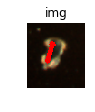

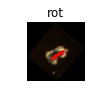

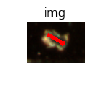

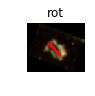

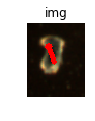

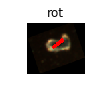

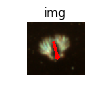

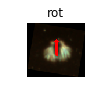

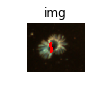

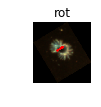

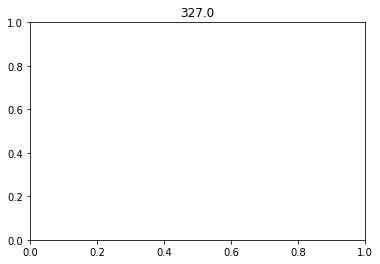

In [6]:
%matplotlib inline
image_dir = '/data5/Plankton_wi18/rawcolor_db/images'
plt.figure()
k = 5
for i,image in enumerate(images):    
    plt.subplot(2,k,i+1)
    img = plt.imread(path.join(image_dir,image))
    
#     border=cv2.copyMakeBorder(img, top=1, bottom=1, left=1, right=1, borderType= cv2.BORDER_CONSTANT, value=[0,0,1] )
#     img = border
    
    h = img.shape[0]
    w = img.shape[1]
    
    head = np.array([[df['head_x'][i]],[df['head_y'][i]]])
    tail = [[df['tail_x'][i]],[df['tail_y'][i]]]

    coordinates = [head[0][0]/float(w),head[1][0]/float(h),tail[0][0]/float(w),tail[1][0]/float(h)]
    show_arrow(img,coordinates,'img')
    plt.title(str(np.rad2deg(angle[i]))[:5])

    M = cv2.getRotationMatrix2D((center[0,i],center[1,i]),np.rad2deg(-rotation_ang[i]),1)

    bounds = np.array([[0,0,1],[img.shape[1],0,1],[0,img.shape[0],1],[img.shape[1],img.shape[0],1]]).T
    bounds_rot = M.dot(bounds)
    min_x = min(bounds_rot[0,:])
    max_x = max(bounds_rot[0,:])
    min_y = min(bounds_rot[1,:])
    max_y = max(bounds_rot[1,:])    
    
    h_new = max_y - min_y
    w_new = max_x - min_x
    tx = np.abs(np.min([min_x,0]))
    ty = np.abs(np.min([min_y,0]))
    
    tx -= np.abs(w_new - np.max([max_x,w_new]))
    ty -= np.abs(h_new - np.max([max_y,h_new]))
    
    bounds_rot = bounds_rot + [[tx],[ty]]
    cosM = np.abs(M[0, 0])
    sinM = np.abs(M[0, 1])

    M[0, 2] += tx
    M[1, 2] += ty
    
    dst = cv2.warpAffine(img,M,(int(np.ceil(w_new)),int(np.ceil(h_new))))
    plt.subplot(2,k,i+1+k)
    head_rot = M.dot(np.vstack((head,[1])))
    tail_rot = M.dot(np.vstack((tail,[1])))
    corrdinates_rot = [head_rot[0][0]/float(dst.shape[1]),head_rot[1][0]/float(dst.shape[0]),tail_rot[0][0]/float(dst.shape[1]),tail_rot[1][0]/float(dst.shape[0])]
    show_arrow(dst,corrdinates_rot,'rot')

    plt.title(str(np.rad2deg(desired_ang[i]))[:5])
    if i == k-1:
        break
plt.show()